In [28]:
import os

import numpy as np
import pandas as pd
from IPython.display import display
from matplotlib import pyplot as plt

# show all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [29]:
# specify the directory you want to use
df = pd.read_csv("data/compas-scores-two-years.csv")

In [30]:
df.shape

(7214, 53)

In [31]:
df["is_male"] = np.where(df.sex == "Male", 1, 0)
df["is_black"] = np.where(df.race == "High", 1, 0)
df["is_felony"] = np.where(df.c_charge_degree == "F", 1, 0)
df["compas_is_recid"] = np.where(df.score_text == "High", 1, 0)

# Analyze whole original table

In [32]:
df.race.value_counts()

race
African-American    3696
Caucasian           2454
Hispanic             637
Other                377
Asian                 32
Native American       18
Name: count, dtype: int64

In [33]:
# columns and shape
print(df.columns)
print(df.shape)

Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event', 'two_year_recid', 'is_male', 'is_black',
       'is_felony', 'compas_is_recid'],
      dty

In [34]:
# Missing rate each columns
df.isna().mean(axis=0)

id                         0.000000
name                       0.000000
first                      0.000000
last                       0.000000
compas_screening_date      0.000000
sex                        0.000000
dob                        0.000000
age                        0.000000
age_cat                    0.000000
race                       0.000000
juv_fel_count              0.000000
decile_score               0.000000
juv_misd_count             0.000000
juv_other_count            0.000000
priors_count               0.000000
days_b_screening_arrest    0.042556
c_jail_in                  0.042556
c_jail_out                 0.042556
c_case_number              0.003050
c_offense_date             0.160660
c_arrest_date              0.842390
c_days_from_compas         0.003050
c_charge_degree            0.000000
c_charge_desc              0.004020
is_recid                   0.000000
r_case_number              0.518852
r_charge_degree            0.518852
r_days_from_arrest         0

# Apply Filtering

In [35]:
# reproduce the samples used in ProPublica analysis
df_filtered = df[(df['days_b_screening_arrest'] <= 30) &
        (df['days_b_screening_arrest'] >= -30) &
        (df['is_recid'] != -1) &
        (df['c_charge_degree'] != 'O') &
        (df['v_score_text'] != 'N/A')]

print(len(df_filtered))

6172


In [36]:
df_filtered["v_score_text"].value_counts()

v_score_text
Low       4117
Medium    1471
High       584
Name: count, dtype: int64

In [37]:
# Identification columns
id_cols = [
    "id",
    "name",
    "first",
    "last",
    "c_case_number",
    "r_case_number",
    "vr_case_number",
]

# Columns that are entirely missing in the dataset
all_missing = ["violent_recid"]

# Columns with only a single unique value
only_one_value = [
    "type_of_assessment",  # Risk of Recidivism
    "v_type_of_assessment",  # Risk of Violence
]

# Date-related columns
date_cols = [
    "compas_screening_date",
    "dob",
    "c_jail_in",
    "c_jail_out",
    "c_offense_date",
    "c_arrest_date",
    "r_offense_date",
    "r_jail_in",
    "r_jail_out",
    "vr_offense_date",
    "screening_date",
    "v_screening_date",
    "in_custody",
    "out_custody",
]

# Columns with high cardinality
high_card = ["c_charge_desc", "r_charge_desc", "vr_charge_desc"]

# Columns used for survival analysis
survival_analysis = [
    "start",
    "end",
    "event",
]

# Columns that cause data leakage
leakage_cols = [
    "r_charge_degree",
    "r_days_from_arrest",
    "is_violent_recid",
    "c_days_from_compas",
    "vr_charge_degree",
]

# Redundant columns
redundant_cols = [
    "priors_count.1",
    "decile_score.1",
    "sex", # converted to "is_male"
    "score_text",
    "v_score_text",
    "age_cat",
    "c_charge_degree", # converted to "is_felony"
]

# Categorical columns
cat_cols = [
    "race",
]

# Numerical columns
num_cols = [
    "is_male",
    "age",
    "juv_fel_count",
    "juv_misd_count",
    "juv_other_count",
    "priors_count",
    "days_b_screening_arrest",
    "is_felony",
]

# Label columns
labels = [
    "v_decile_score",
    "decile_score",
    "is_recid",
    "two_year_recid",
    "compas_is_recid"
]

# Combine all column lists into one
all_cols = (
    id_cols
    + all_missing
    + only_one_value
    + date_cols
    + high_card
    + survival_analysis
    + leakage_cols
    + redundant_cols
    + cat_cols
    + num_cols
    + labels
)
len(all_cols)

56

In [38]:
feature_cols = cat_cols + num_cols

X_filtered = df_filtered[feature_cols]
Y_filtered = df_filtered[labels]

In [39]:
X_filtered.is_male.value_counts()

is_male
1    4997
0    1175
Name: count, dtype: int64

In [40]:
X_filtered.shape

(6172, 9)

In [41]:
X_filtered.race.value_counts()

race
African-American    3175
Caucasian           2103
Hispanic             509
Other                343
Asian                 31
Native American       11
Name: count, dtype: int64

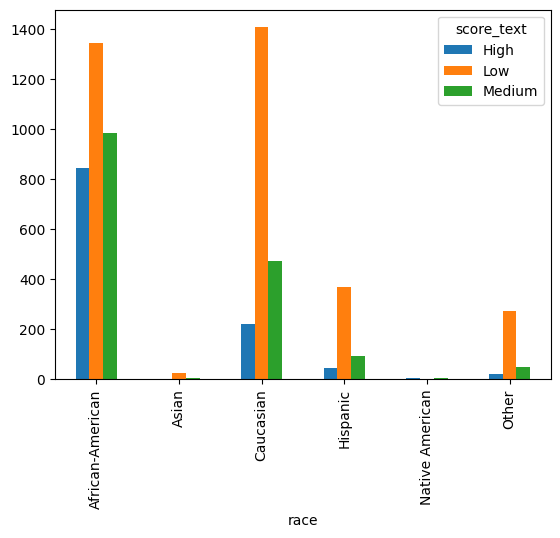

In [42]:
text_by_race = df_filtered.groupby(["race", "score_text"], sort=True)["is_recid"].size()
text_by_race.unstack().plot.bar(stacked=False)
plt.show()

In [43]:
X_filtered

,race,is_male,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,is_felony
0,Other,1,69,0,0,0,0,-1.0,1
1,African-American,1,34,0,0,0,0,-1.0,1
2,African-American,1,24,0,0,1,4,-1.0,1
5,Other,1,44,0,0,0,0,0.0,0
6,Caucasian,1,41,0,0,0,14,-1.0,1
...,...,...,...,...,...,...,...,...,...
7209,African-American,1,23,0,0,0,0,-1.0,1
7210,African-American,1,23,0,0,0,0,-1.0,1
7211,Other,1,57,0,0,0,0,-1.0,1
7212,African-American,0,33,0,0,0,3,-1.0,0


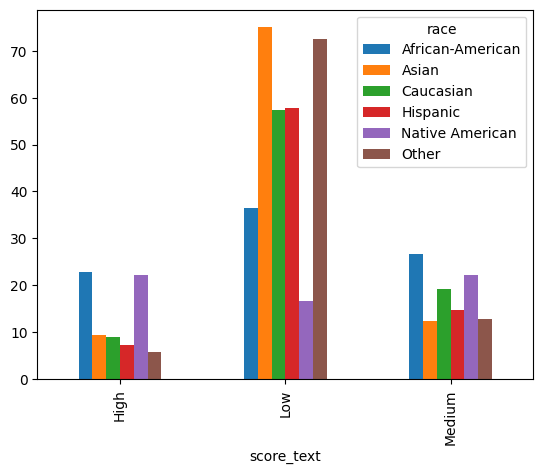

In [44]:
text_by_race = df_filtered.groupby(["race", "score_text"], sort=True).size().reset_index()
text_by_race = text_by_race.rename(columns={0:"count"})
text_by_race[["count"]] = text_by_race[["count"]].apply(pd.to_numeric)
gb = df.groupby(["race"]).size().reset_index()
gb_d = gb.set_index("race").to_dict().get(0)
text_by_race["count_percentage"] = text_by_race.apply(lambda x: ((int(x["count"])/int(gb_d.get(x["race"]))) * 100), axis=1)
text_by_race.groupby(["score_text", "race"])["count_percentage"].mean().unstack().plot.bar(stacked=False)
plt.show()

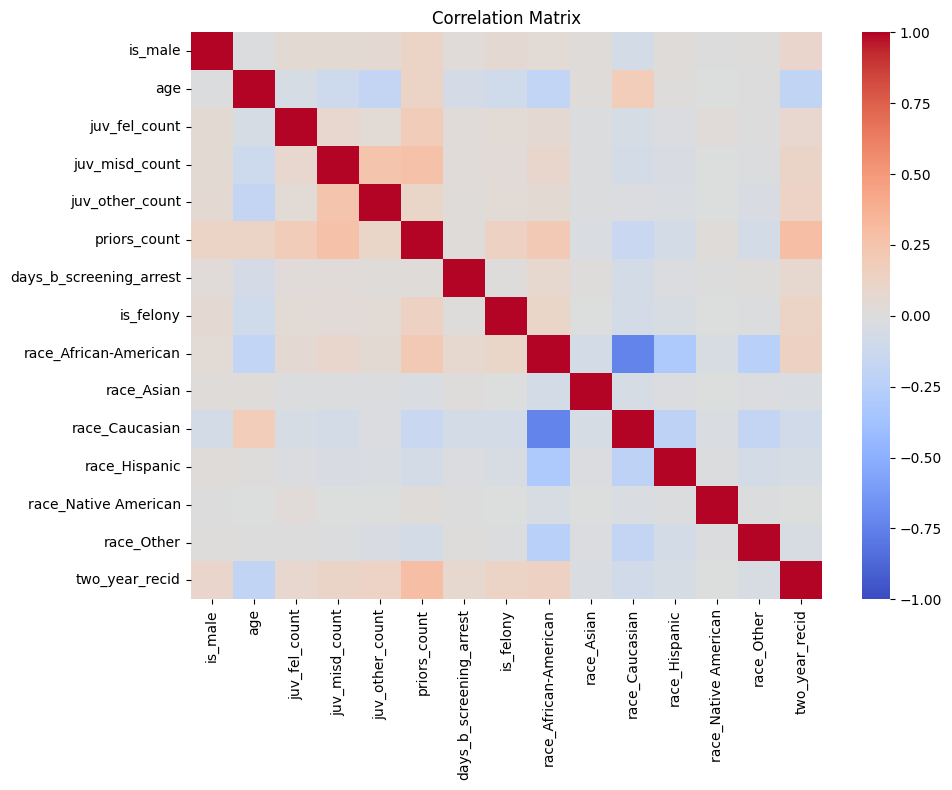

Top correlations with two_year_recid:
two_year_recid             1.000000
priors_count               0.290607
race_African-American      0.140609
juv_other_count            0.125910
is_felony                  0.120332
juv_misd_count             0.110298
is_male                    0.100911
juv_fel_count              0.081715
days_b_screening_arrest    0.074836
race_Native American      -0.000049
race_Asian                -0.028115
race_Other                -0.045596
race_Hispanic             -0.050453
race_Caucasian            -0.092754
age                       -0.189180
Name: two_year_recid, dtype: float64


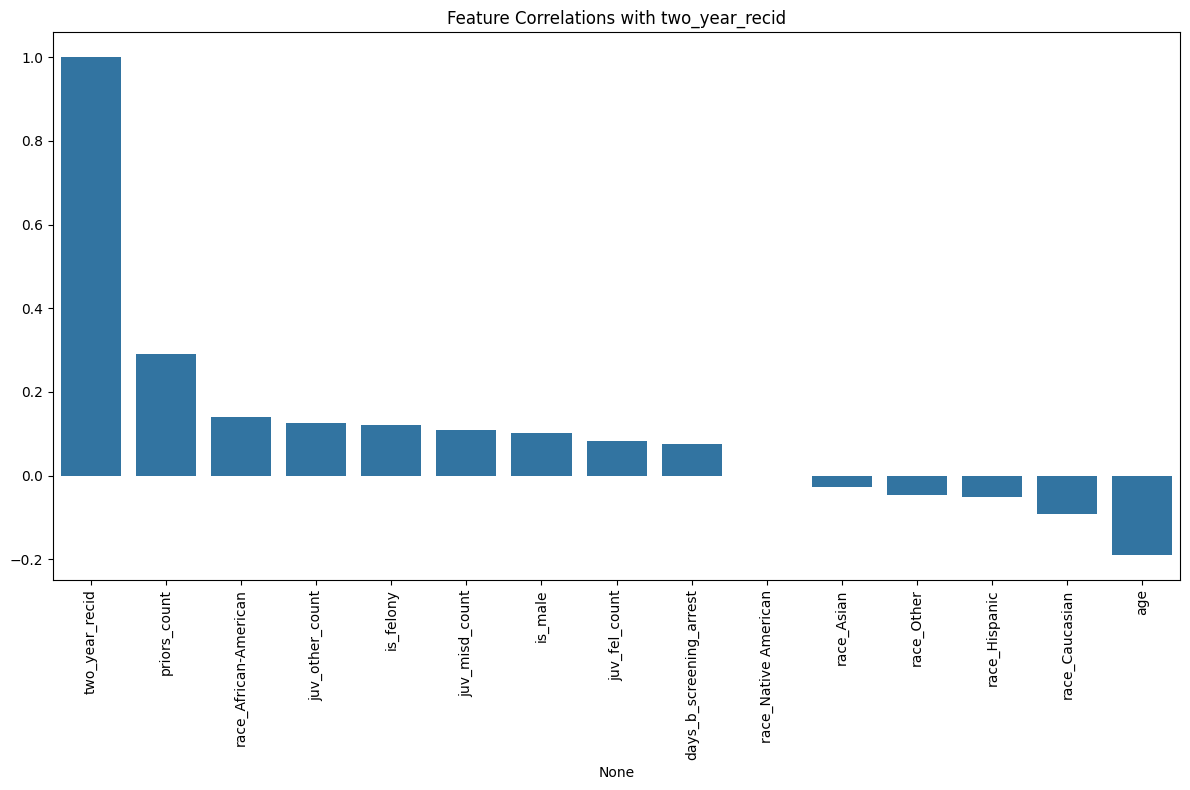

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

# Assuming your data is in a DataFrame called 'df'

# Select relevant features and the target variable
# selected_features = [
#     "age",
#     "sex",
#     "race",
#     "juv_fel_count",
#     "juv_misd_count",
#     "juv_other_count",
#     "priors_count",
#     "c_charge_degree",
#     "age_cat",
#     "days_b_screening_arrest",
# ]

selected_features = num_cols + cat_cols

target = "two_year_recid"

new_cat_cols = [r for r in cat_cols if r in selected_features]
new_num_cols = [r for r in num_cols if r in selected_features]

# Apply one-hot encoding to categorical features
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
encoded_features = encoder.fit_transform(X=df_filtered[new_cat_cols])
encoded_feature_names = encoder.get_feature_names_out(new_cat_cols).tolist()

df_encoded = pd.DataFrame(
    encoded_features, columns=encoded_feature_names, index=df_filtered.index
)

# Combine encoded categorical features with numerical features
df_final = pd.concat([df_filtered[new_num_cols], df_encoded, df_filtered[target]], axis=1)

# # Remove duplicated columns
# df_final = df_final.loc[:, ~df_final.columns.duplicated()]

# Calculate and visualize the correlation matrix
corr_matrix = df_final.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", vmin=-1, vmax=1, center=0)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

# Focus on correlations with the target variable
target_correlations = corr_matrix[target].sort_values(ascending=False)
print("Top correlations with two_year_recid:")
print(target_correlations)

plt.figure(figsize=(12, 8))
sns.barplot(x=target_correlations.index, y=target_correlations.values)
plt.title("Feature Correlations with two_year_recid")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [46]:
target_df = df_filtered[labels]
target_df

,v_decile_score,decile_score,is_recid,two_year_recid,compas_is_recid
0,1,1,0,0,0
1,1,3,1,1,0
2,3,4,1,1,0
5,1,1,0,0,0
6,2,6,1,1,0
...,...,...,...,...,...
7209,5,7,0,0,0
7210,5,3,0,0,0
7211,1,1,0,0,0
7212,2,2,0,0,0


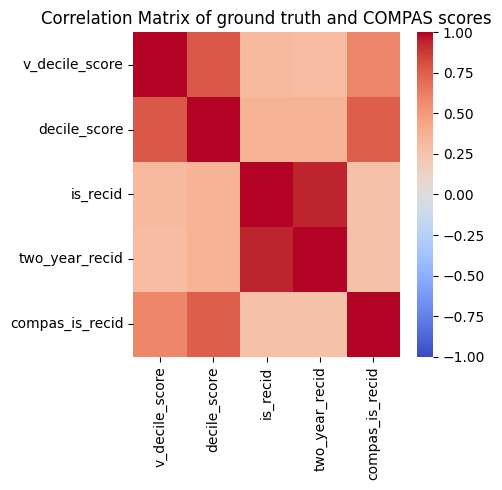

In [47]:
# Calculate and visualize the correlation matrix
corr_matrix = df_filtered[labels].corr()

plt.figure(figsize=(5, 5))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", vmin=-1, vmax=1, center=0)
plt.title("Correlation Matrix of ground truth and COMPAS scores")
plt.tight_layout()
plt.show()

In [48]:
df_filtered.two_year_recid.value_counts()

two_year_recid
0    3363
1    2809
Name: count, dtype: int64

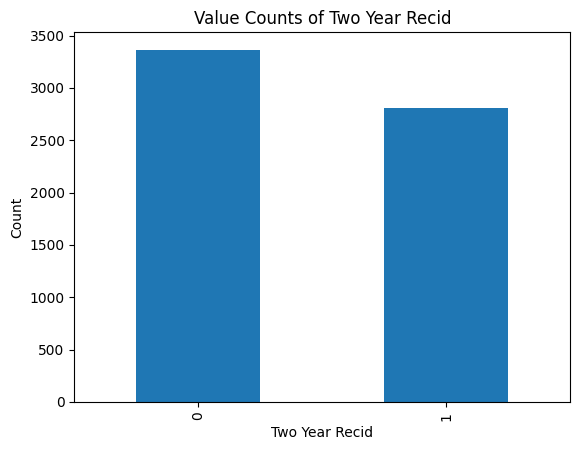

In [51]:
import matplotlib.pyplot as plt

df_filtered.two_year_recid.value_counts().plot(kind='bar')
plt.xlabel('Two Year Recid')
plt.ylabel('Count')
plt.title('Value Counts of Two Year Recid')
plt.show()

In [50]:
df_filtered.two_year_recid.value_counts(normalize=True)

two_year_recid
0    0.54488
1    0.45512
Name: proportion, dtype: float64

In [21]:
# check performance of compas model

from sklearn.metrics import classification_report

print(
    classification_report(
        y_true=df_filtered["two_year_recid"], y_pred=df_filtered["compas_is_recid"]
    )
)

              precision    recall  f1-score   support

           0       0.61      0.91      0.73      3363
           1       0.74      0.30      0.43      2809

    accuracy                           0.63      6172
   macro avg       0.68      0.61      0.58      6172
weighted avg       0.67      0.63      0.59      6172



In [25]:
df_filtered.decile_score / 10

0       0.1
1       0.3
2       0.4
5       0.1
6       0.6
       ... 
7209    0.7
7210    0.3
7211    0.1
7212    0.2
7213    0.4
Name: decile_score, Length: 6172, dtype: float64

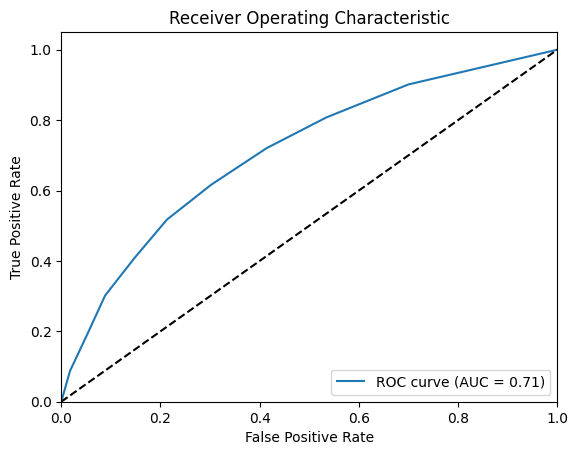

In [27]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_score):
    # Compute the false positive rate (fpr) and true positive rate (tpr)
    fpr, tpr, _ = roc_curve(y_true, y_score)

    # Compute the area under the ROC curve (AUC)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()


plot_roc_curve(y_true=df_filtered["two_year_recid"], y_score=df_filtered.decile_score / 10)